In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
import missingno as msno
import utils
import numpy as np
from os import path

#DATASET_PATH='../dataset/races.csv'

DATASET_PATH=path.join('..','dataset','races.csv')
races_df=pd.read_csv(DATASET_PATH,
                     parse_dates=['date'],
                     #dtype=RACES_DTYPES
                     )
races_df['delta']=pd.to_timedelta(races_df['delta'],'seconds',errors='ignore')

/tmp/ipykernel_997/4155322922.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_timedelta without passing `errors` and catch exceptions explicitly instead
  races_df['delta']=pd.to_timedelta(races_df['delta'],'seconds',errors='ignore')


In [2]:
races_df.head()

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
0,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,0,sean-kelly,22.0,True,False,False,vini-ricordi-pinarello-sidermec-1986,0 days
1,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,1,gerrie-knetemann,27.0,True,False,False,norway-1987,0 days
2,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,2,rene-bittinger,24.0,True,False,False,NaN,0 days
3,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,3,joseph-bruyere,30.0,True,False,False,navigare-blue-storm-1993,0 days
4,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,4,sven-ake-nilsson,27.0,True,False,False,spain-1991,0 days


# Cyclists data quality analysis

This notebook takes care of the data quality assessment for the cyclists data.

## dataset description
First we need to describe the dataset and the meaning of it's values to understand the analysis.

We have a tabular dataset composed by the following features:
- _url: unique identifier, it is composed of a string mad by the name of the races,the year and the stage, it is coded with a string.
- name: name of the race, coded with a string.
- points: pointss assigned to the race, coded with an integer in the range $[0,+\infty)$.
- uci_points: alternative points assigned to the race,coded with an integer in the range $[0,+\infty)$.
- length: total meters length of the race, coded with a floating point value in the range $[0,+\infty)$.
- climb_total: total meters climbed during the race,coded with a floating point value in the range $[0,+\infty)$.
- profile: the profile of the race, coded with integer values in the range \[1,2,3,4,5\].
- starlist_quality: quality of the participant, coded with an integer in the range $[0,+\infty)$.
- average_temperature: average temperature in celsius, coded with a float in the range $(-\infty,+\infty)$.
- position: position of the participant for that stage, coded with an integer in the range $[0,+\infty)$.
- cyclist: cyclist identifier, coded with a string.
- is_tarmac: boolean flag identifying the terrain is tarmac or not, coded with a boolean.
- is_cobbled: boolean flag identifying the terrain is tarmac or not, coded with a boolean.
- is_gravel: boolean flag identifying the terrain is tarmac or not, coded with a boolean.
- cyclist_team: team of the cyclist, coded with a string.
- date: date the race took place, coded using the datetime data type.
- delta: it's difference between the first person to arrive and the participant coded using the deltatime datatype, the value is expected to be non-negative.

## preliminary analysis

A first dumb check evidences no duplicate rows (at least across all features).

In [3]:
len(races_df[races_df.duplicated()])

0

A first preliminary analysis we can show how many values are currently missing from the dataset.

In [4]:
mv_df=pd.DataFrame(races_df.isnull().sum())
mv_df=mv_df.rename(columns={0:'missing values'})
mv_df['missing values']=mv_df['missing values'].astype('int')
mv_df['missing values %']=((mv_df['missing values']/len(races_df))*100).round(3)
mv_df.sort_values('missing values',ascending=False)

mv_cols=list(mv_df[mv_df['missing values'] > 0].index)
mv_cols.append('date')

mv_df

,missing values,missing values %
_url,0,0.000
name,0,0.000
points,477,0.081
uci_points,338779,57.433
length,0,0.000
climb_total,147045,24.929
profile,148194,25.123
startlist_quality,0,0.000
average_temperature,559932,94.925
date,0,0.000


The most missing features are the average temperature with almost all values missing, uci_points has more than half of it values missing and we also have the cyclist_team,profile and climb_total have around 25% of their values missing.
For all the other attributes the missing values are very few or none at all.

We can obtain a better visualization through a bar plot:

/home/mirdan08/DataMiningProject/src/task1_data_understanding/utils.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  values['all other features'] = 0


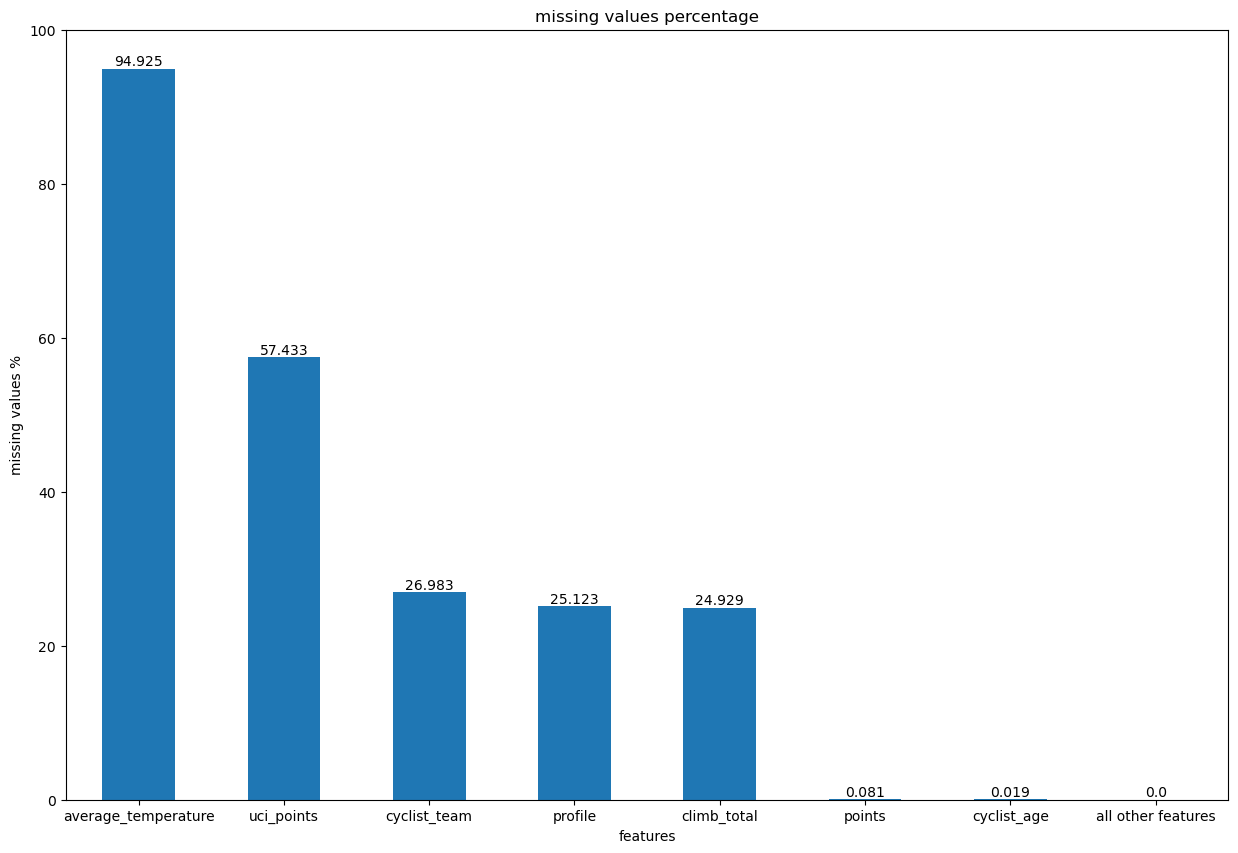

In [5]:
utils.plot_missing_values_barplot(mv_df)

# features in-domain analysis
We can do a first analysis on single features taking care of possible missing values,out-of-domain values or default values.
We can start with the analysis of the first two values.

## `_url` and `name`


The first attribute is redundant and contains duplicate information with no wrong or missing values w.r.t. to its duplicates, below we can see that the name of the race is correct and same goes for the year for each entry in the dataset.

Note: checking the name in `_url` to match the `name` feature is useless since the name attribute in the orginal dataset contains different values for the same races and cannot be confronted with the name contained in the `_url` attribute, but the name contained in _url is useful as it is standardized and avoids ambiguity.

In [5]:
# the feature has useful information to be used further in the analysis
url_df=races_df['_url'].str.split('/',expand=True)
url_df.rename(columns={0:'name',1:'year',2:'stage'},inplace=True)
url_df['original_name']=races_df['name']
url_df['original_year']=races_df['date'].dt.year.astype('int32')
url_df['year']=url_df['year'].astype('int32')
correct_years=len(url_df[url_df['original_year']==url_df['year']])
print(len(url_df)-correct_years)

0


## numerical values analysis

this part analises all the various numerical attributes checking if their non missing values are within their domain.

In [7]:
points=races_df['points'].dropna()
print('values lower than 0:',len(points[points<0]))

values lower than 0: 0


In [8]:
uci_points=races_df['uci_points'].dropna()
print('values lower than 0:',len(uci_points[uci_points<0]))

values lower than 0: 0


In [9]:
length=races_df['length'].dropna()
print('values lower than 0:',len(length[length<=0]))

values lower than 0: 0


In [10]:
climb_total=races_df['climb_total'].dropna()
print('values lower than 0:',len(climb_total[climb_total<=0]))

values lower than 0: 0


In [11]:
startlist_quality=races_df['startlist_quality'].dropna()
print('values lower than or equal to 0:',len(startlist_quality[startlist_quality<=0]))

values lower than or equal to 0: 0


In [12]:
average_temperature=races_df['average_temperature'].dropna()
print('average temperature values range',average_temperature.min(),"to",average_temperature.max())

average temperature values range 10.0 to 36.0


In [13]:
position=races_df['position'].dropna()
print('values lower than 0:',len(position[position<0]))

values lower than 0: 0


In [14]:
cyclist_age=races_df['cyclist_age'].dropna()
print('values lower than 0:',cyclist_age.min(),cyclist_age.max())

values lower than 0: 13.0 56.0


In [15]:
delta=races_df['delta'].dropna()
print('values lower than 0:',len(delta[delta<pd.Timedelta(0)]))

values lower than 0: 86


From these we can infer that all numerical values have correct values within range except for delta which has some values that are not.
## date analysis

We can continue with other kind of attributes, first the dates.

In [16]:
dates=races_df['date'].dropna()
print(dates.min(),dates.max())

1970-02-28 04:52:00 2023-07-29 05:52:14


The dates are all within a sensed range.

## profile analysis

We can now analise the profile for the races which is coded as integers in the range \[1,2,3,4,5\].

In [17]:
profile=races_df['profile'].dropna()
# values are coded with integers from 1 to 5
domain_values=[1,2,3,4,5]
print('out of range values :',len(profile[~profile.isin(domain_values)]))

out of range values : 0


Also here we don't have any range issues.

## is_X analysis

As for the is_X values we should have at least one flag True for each row

([<matplotlib.patches.Wedge at 0x7fec0497efc0>,
 [Text(-1.055113366015054, 0.3110237689572657, 'at least one flag'),
  Text(1.0551133587350172, -0.3110237936539762, 'no flags')],
 [Text(-0.5755163814627567, 0.1696493285221449, '90.88'),
  Text(0.5755163774918275, -0.1696493419930779, '9.12')])

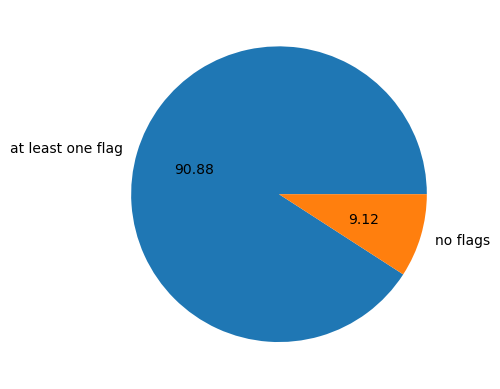

In [18]:
is_X_df=races_df[['is_tarmac','is_cobbled','is_gravel']]
is_X_value=is_X_df.sum(axis=1).value_counts().values

plt.pie(x=is_X_value,
        labels=[
                f'at least one flag',
                f'no flags'
        ] ,
        autopct='%1.2f',
        )

But as we can see that is not true, it should be determined if the terrain can be another type or is just missing the values.

# races names

We can now analize the names of the races.

In [19]:
names=races_df['name'].unique()
names.sort()
names,len(names)

(array(['Amstel Gold Race', 'Clasica Ciclista San Sebastian',
        'Clásica Ciclista San Sebastian', 'Clásica Ciclista San Sebastián',
        'Clásica San Sebastián', 'Criterium du Dauphiné',
        'Criterium du Dauphiné Libére', 'Critérium du Dauphiné',
        'Critérium du Dauphiné Libéré', 'Donostia San Sebastian Klasikoa',
        'Dwars door België / À travers la Belgique',
        'Dwars door Vlaanderen',
        'Dwars door Vlaanderen - A travers la Flandre ME',
        'Dwars door Vlaanderen / A travers la Flandre',
        'Dwars door Vlaanderen / A travers la Flandre ME',
        'E3 BinckBank Classic', 'E3 Harelbeke', 'E3 Prijs Vlaanderen',
        'E3 Prijs Vlaanderen - Harelbeke', 'E3 Saxo Bank Classic',
        'E3 Saxo Classic', 'E3-Prijs Harelbeke', "Giro d'Italia",
        'Giro di Lombardia', 'Gran Camiño',
        'Grand Prix Cycliste de Montréal', 'Grand Prix Cycliste de Quebec',
        'Grand Prix Cycliste de Québec', 'Il Lombardia',
        'Itzulia Basque

By observing the output we can see that some races have duplicate names with some syntax errors, so we could have duplicates or have different races for some of them i.e. they are the same race with different name or a different race at all.

In [20]:
normalized_names={utils.normalize_text(name) for name in names}
normalized_names,len(normalized_names)

({'amstel gold race',
  'clasica ciclista san sebastian',
  'clasica san sebastian',
  'criterium du dauphine',
  'criterium du dauphine libere',
  'donostia san sebastian klasikoa',
  'dwars door belgie  a travers la belgique',
  'dwars door vlaanderen',
  'dwars door vlaanderen  a travers la flandre',
  'dwars door vlaanderen  a travers la flandre me',
  'e3 binckbank classic',
  'e3 harelbeke',
  'e3 prijs vlaanderen',
  'e3 prijs vlaanderen  harelbeke',
  'e3 saxo bank classic',
  'e3 saxo classic',
  'e3prijs harelbeke',
  'giro di lombardia',
  'giro ditalia',
  'gran camino',
  'grand prix cycliste de montreal',
  'grand prix cycliste de quebec',
  'il lombardia',
  'itzulia basque country',
  'la fleche wallonne',
  'la vuelta ciclista a espana',
  'liege  bastogne  liege',
  'liegebastogneliege',
  'milanosanremo',
  'monte paschi eroica',
  'montepaschi strade bianche  eroica toscana',
  'o gran camino',
  'omloop het nieuwsblad me',
  'omloop het volk',
  'omloop het volk me

As we can see even after some normalization getting useful information is still difficult, this difficulty can be workaround using the information contained in the _url attribute which has normalized values and doesn't contain in ambiguity.

An interesting observation is that races ocur multiple times with different names sometimes we can also have some innsight on the category e.g. ME=Men Elite for tour de france, it is to be determined wether we are still talking about thesame race but in different categories across different years.

## missing values matrix across time

We've seen until now just the single missing values, to understand better our dataset we can correlate missing values with time to see any meaningful pattern.

                               _url            name  points  uci_points  \
0       tour-de-france/1978/stage-6  Tour de France   100.0         NaN   
1       tour-de-france/1978/stage-6  Tour de France   100.0         NaN   
2       tour-de-france/1978/stage-6  Tour de France   100.0         NaN   
3       tour-de-france/1978/stage-6  Tour de France   100.0         NaN   
4       tour-de-france/1978/stage-6  Tour de France   100.0         NaN   
...                             ...             ...     ...         ...   
589860   giro-d-italia/2010/stage-1   Giro d'Italia    80.0        16.0   
589861   giro-d-italia/2010/stage-1   Giro d'Italia    80.0        16.0   
589862   giro-d-italia/2010/stage-1   Giro d'Italia    80.0        16.0   
589863   giro-d-italia/2010/stage-1   Giro d'Italia    80.0        16.0   
589864   giro-d-italia/2010/stage-1   Giro d'Italia    80.0        16.0   

          length  climb_total  profile  startlist_quality  \
0       162000.0       1101.0      1.0

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

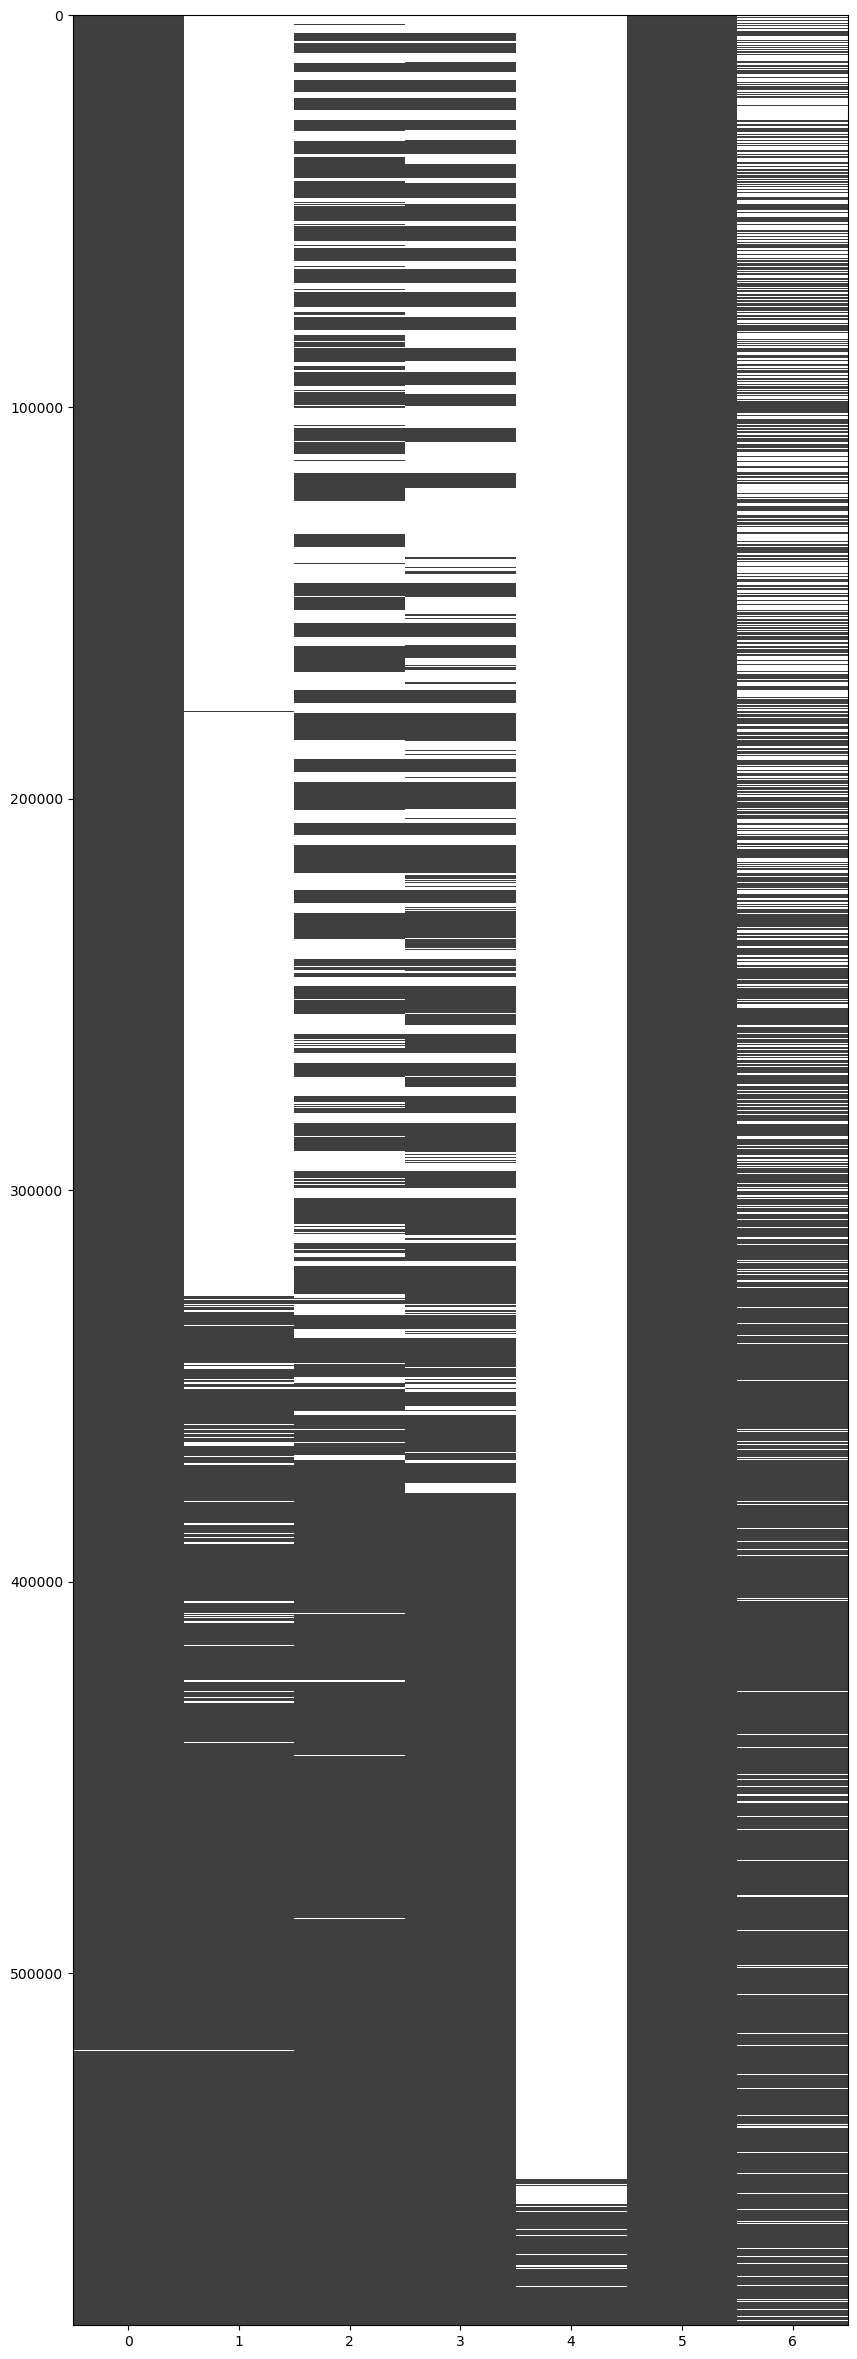

In [25]:
utils.plot_msno_matrix(races_df[mv_cols])

As we can see uci_points are missing until 2000 while the average temperature is missing until 2020. Also climb_total and profile have some gaps until 2004 where they stop missing entirely while cyclist_team has some missing values across all the years with a concentration on years before 1998.

## missing values correlation heatmap

Observing the plot above we can see that profile and climb total seem to be highly correlated and both are present or missing together, this can be proved by plotting a missing values correlation map below.

<Axes: >

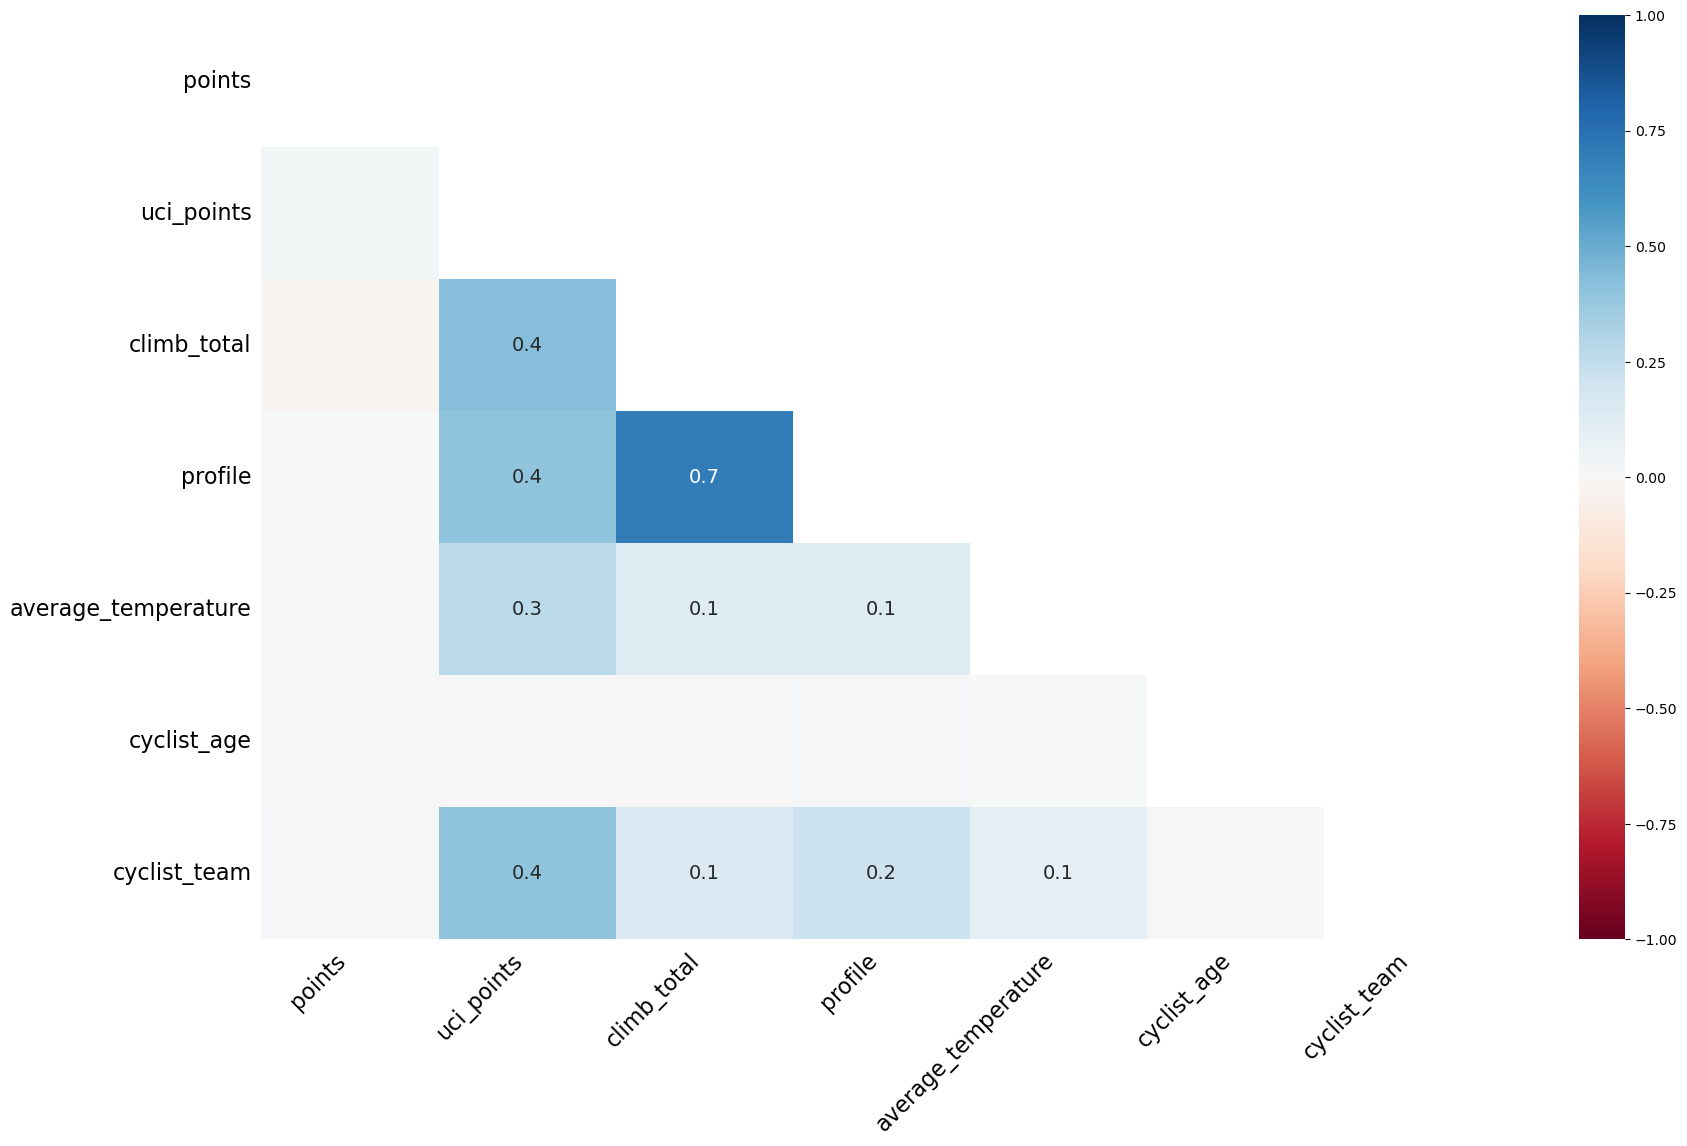

In [22]:
msno.heatmap(races_df)

# missing values per race

Finally another interesting insight is the missing values per race.

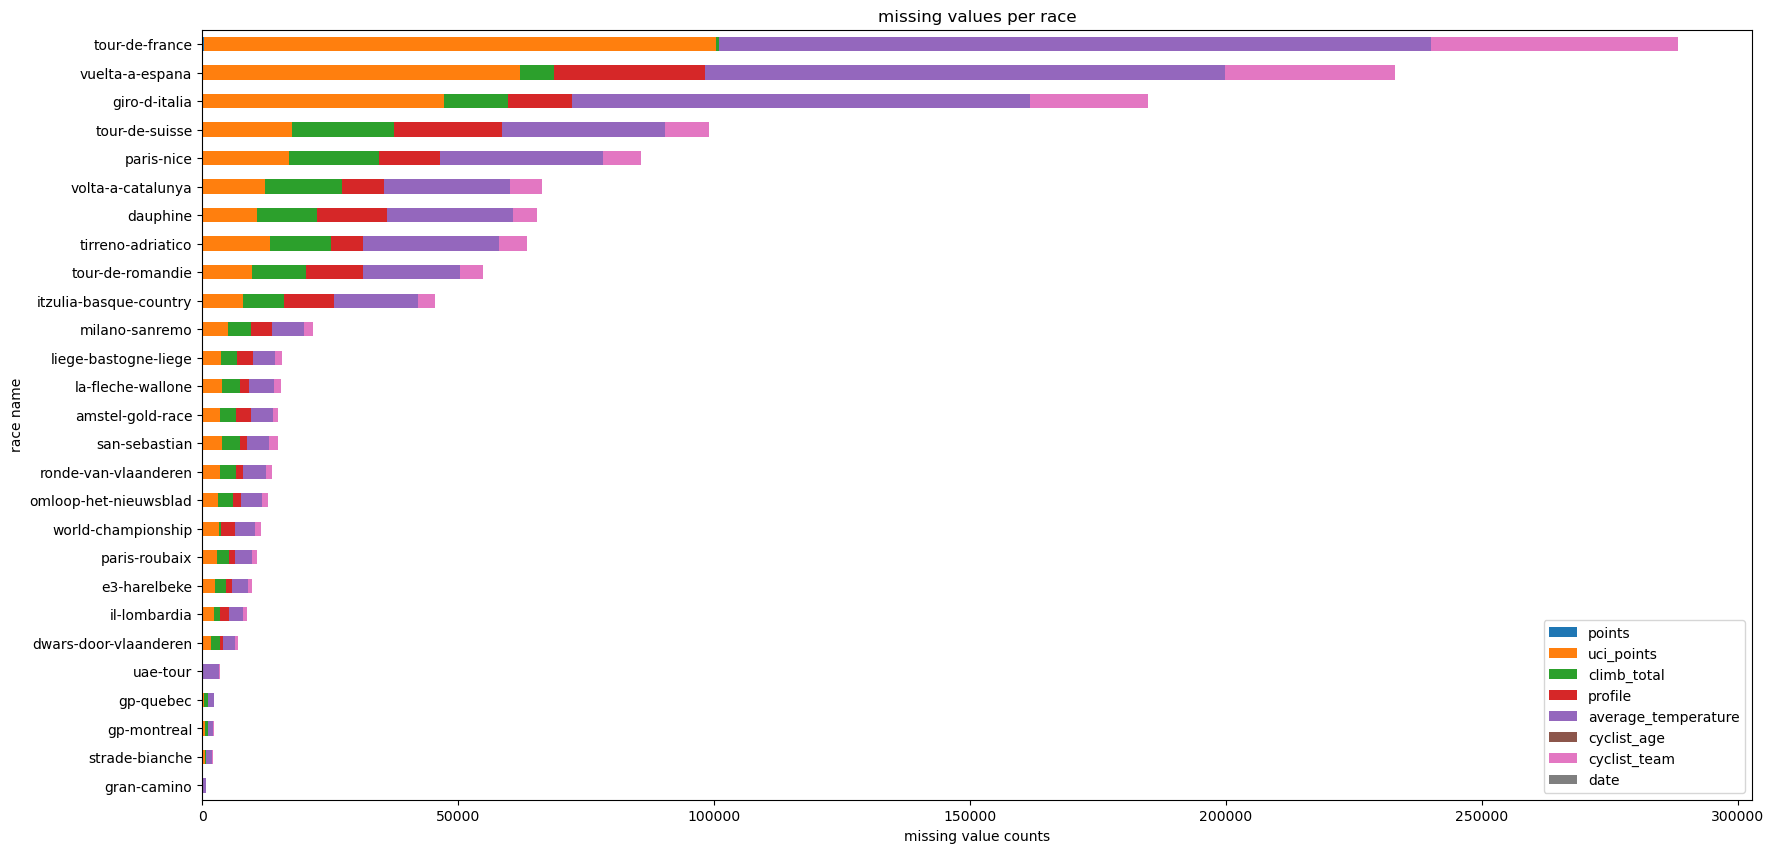

In [23]:
utils.plot_races_mv(races_df,url_df,mv_cols)

As we can see the most missing value, as to be expected, is the average temperature along with uci_points.

In [7]:
import re


races_df_ext=races_df.copy()

races_df_ext['std_name']=url_df['name']
#parse the value format for the stage
races_df_ext['stage']=url_df['stage'].str.split('-',expand=True)[1]
#if Non is a value then the split is useless, restore the old value
races_df_ext.loc[url_df['stage']=='prologue','stage']='prologue'
races_df_ext.loc[url_df['stage']=='result','stage']='result'
races_df_ext

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta,std_name,stage
0,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,0,sean-kelly,22.0,True,False,False,vini-ricordi-pinarello-sidermec-1986,0 days 00:00:00,tour-de-france,6
1,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,1,gerrie-knetemann,27.0,True,False,False,norway-1987,0 days 00:00:00,tour-de-france,6
2,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,2,rene-bittinger,24.0,True,False,False,NaN,0 days 00:00:00,tour-de-france,6
3,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,3,joseph-bruyere,30.0,True,False,False,navigare-blue-storm-1993,0 days 00:00:00,tour-de-france,6
4,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,4,sven-ake-nilsson,27.0,True,False,False,spain-1991,0 days 00:00:00,tour-de-france,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589860,giro-d-italia/2010/stage-1,Giro d'Italia,80.0,16.0,8400.0,60.0,1.0,878,NaN,2010-05-08 00:11:38,192,anders-lund-1,25.0,True,False,False,watney-avia-1972,0 days 00:01:20,giro-d-italia,1
589861,giro-d-italia/2010/stage-1,Giro d'Italia,80.0,16.0,8400.0,60.0,1.0,878,NaN,2010-05-08 00:11:40,193,andrea-masciarelli,28.0,True,False,False,NaN,0 days 00:01:22,giro-d-italia,1
589862,giro-d-italia/2010/stage-1,Giro d'Italia,80.0,16.0,8400.0,60.0,1.0,878,NaN,2010-05-08 00:11:41,194,marco-corti,24.0,True,False,False,kazakhstan-2001,0 days 00:01:23,giro-d-italia,1
589863,giro-d-italia/2010/stage-1,Giro d'Italia,80.0,16.0,8400.0,60.0,1.0,878,NaN,2010-05-08 00:11:48,195,robbie-mcewen,38.0,True,False,False,radio-popular-paredes-boavista-2023,0 days 00:01:30,giro-d-italia,1


In [25]:
set(races_df_ext['stage'])

{'0',
 '1',
 '10',
 '10a',
 '10b',
 '11',
 '12',
 '12a',
 '12b',
 '13',
 '14',
 '15',
 '15a',
 '15b',
 '16',
 '16a',
 '16b',
 '17',
 '18',
 '18a',
 '18b',
 '19',
 '1a',
 '1b',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '2a',
 '2b',
 '3',
 '3a',
 '3b',
 '4',
 '4a',
 '4b',
 '5',
 '5a',
 '5b',
 '6',
 '6a',
 '6b',
 '7',
 '7a',
 '7b',
 '8',
 '8a',
 '8b',
 '9',
 '9a',
 '9b',
 'prologue',
 'result'}

/tmp/ipykernel_78421/900124586.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  races_mv_df=races_mv_df.groupby('cyclist_team').apply(lambda x: x.isnull().sum())


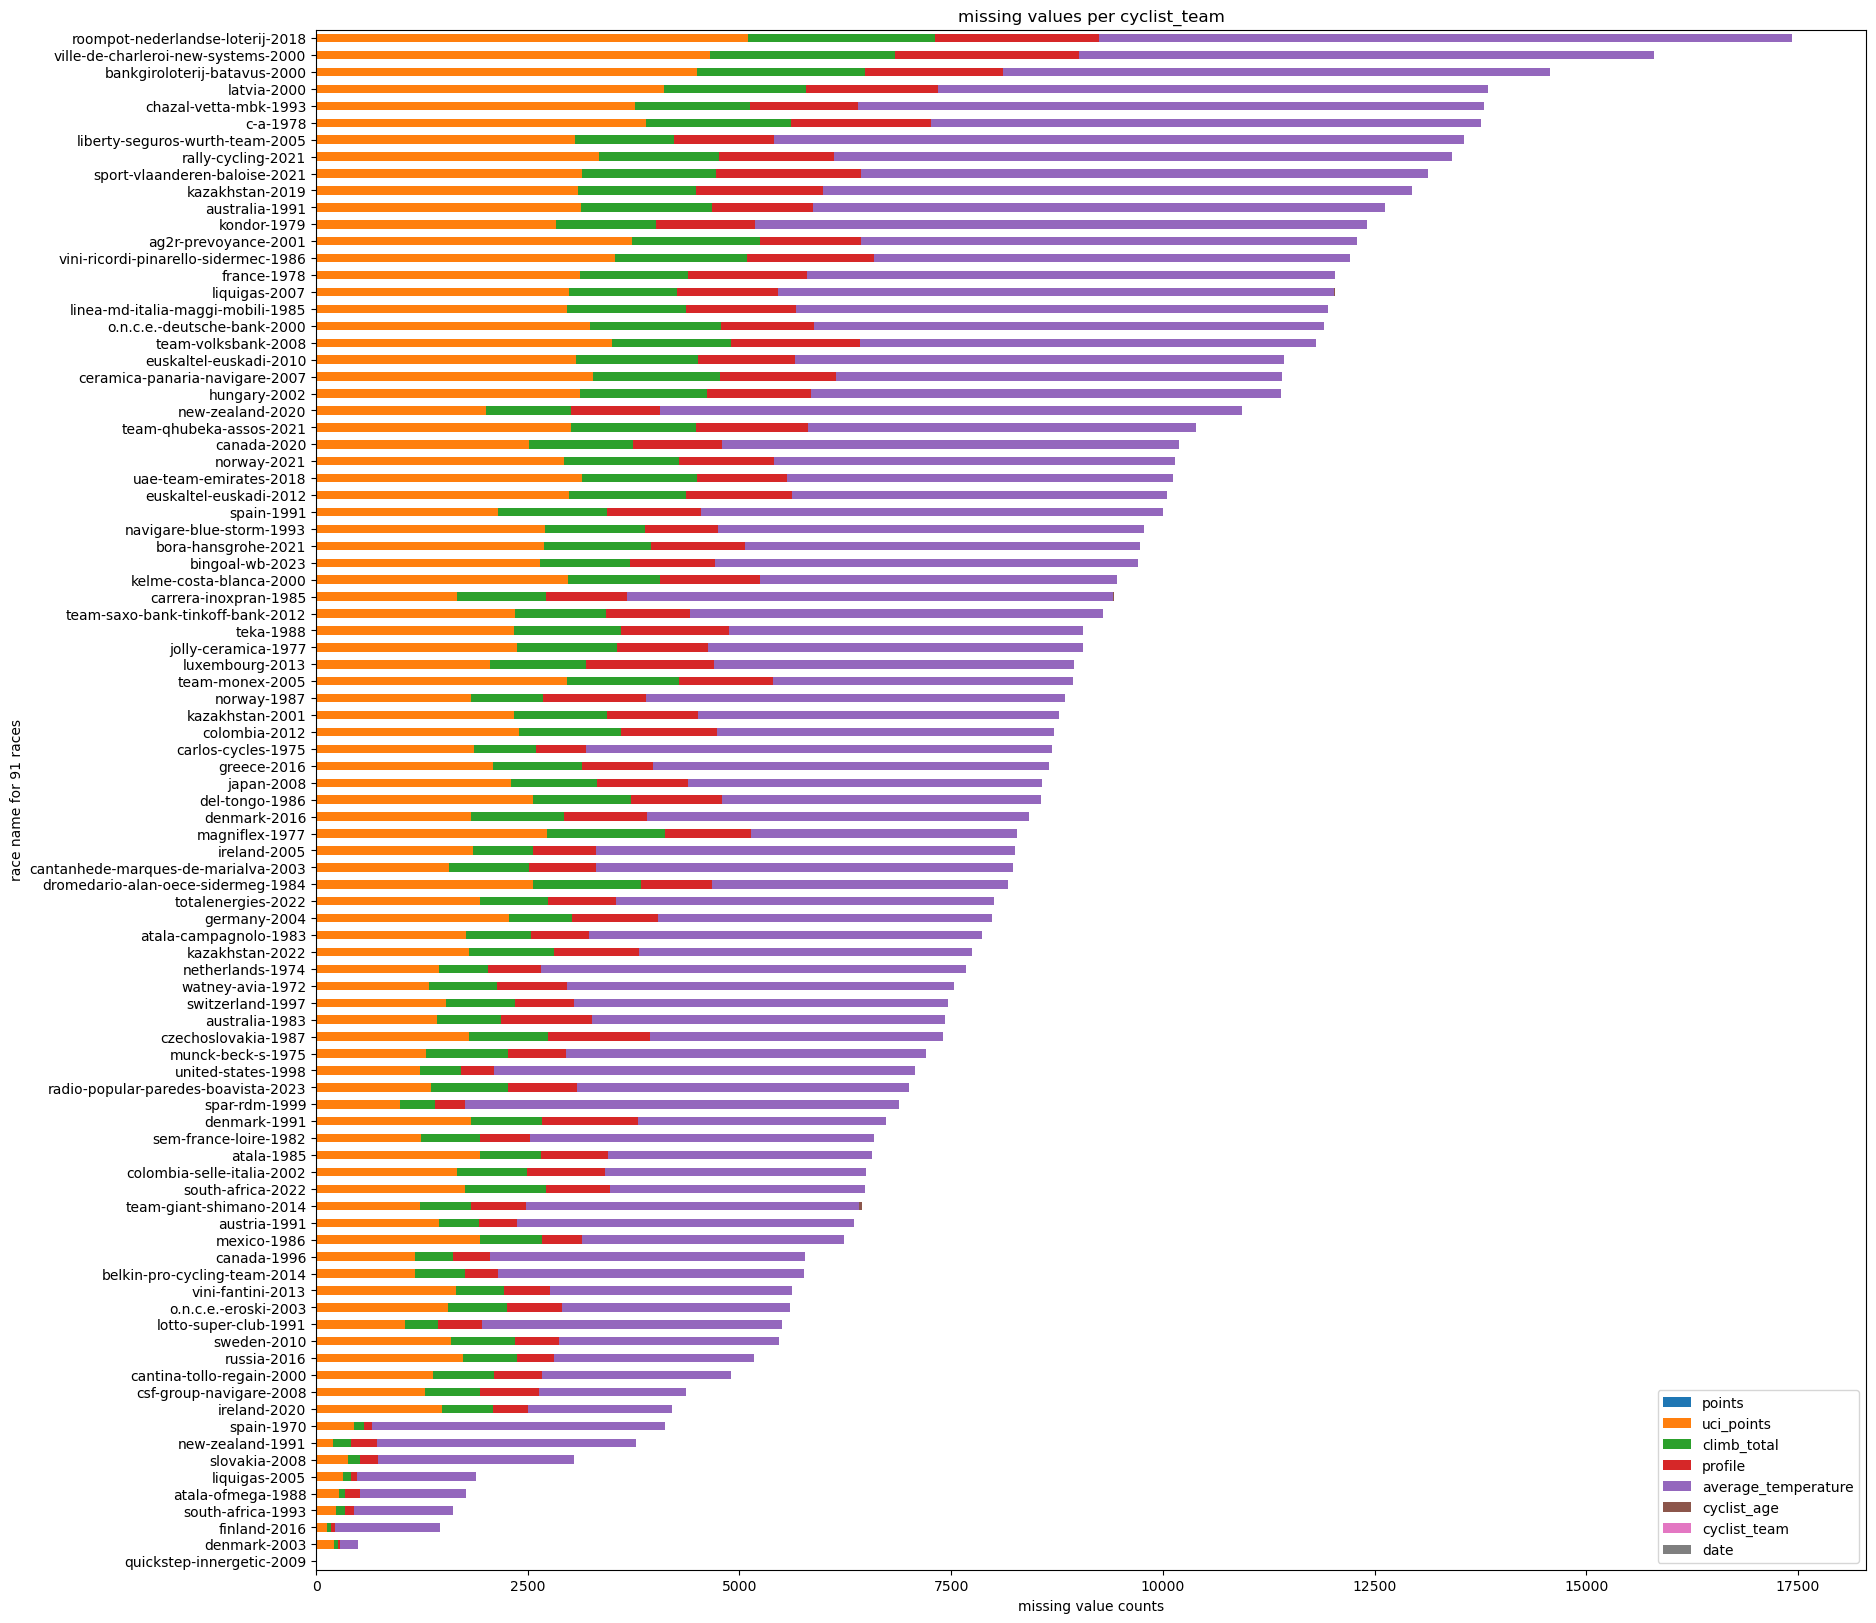

In [26]:
def plot_cyclist_team_mv(races_df,mv_cols):
    races_mv_df=races_df
    races_mv_df=races_mv_df.groupby('cyclist_team').apply(lambda x: x.isnull().sum())
    races_mv_ord=races_mv_df.sum(axis=1).sort_values().index
    races_mv_df[mv_cols].reindex(races_mv_ord).plot(kind='barh',stacked=True,figsize=(20,20),title='missing values per cyclist_team',xlabel='missing value counts',ylabel=f'race name for {len(races_mv_df)} races',use_index=True)

plot_cyclist_team_mv(races_df,mv_cols)

as we can from a quantitative perspective there is no clear trend for teams with missing values except for one with no missing values, it is difficult to observe any useful insight on the cyclists teams. We could narrow down the attributes to the ones of our interest and see if any useful insight pops out this time. For this reason we analise only the cyclist age which is related to the cyclists.

In [27]:
utils.plot_cyclist_team_mv(races_df,['cyclist_age'])

AttributeError: module 'utils' has no attribute 'plot_cyclist_team_mv'

Here we can actually gain useful insight observing how it seems that most missing values for the ages are concentrated within few teams actually. As for the usefulnes to our purpose we have top consider that this could derive from external reasons and is still a useful information to obtain.

# imputation

Given our previous observations we now proceed to fill in missing values using tbe facts we just discovered, also the dataset will be engineered by adding new features and removing/modifying the ones already present.

# cyclist_team

For the cyclist team it is difficult to infer teams without doing manual checking or referring to the internet for informations, a sensible idea would be to assign the unknown teams to the nationality of the country they come from.

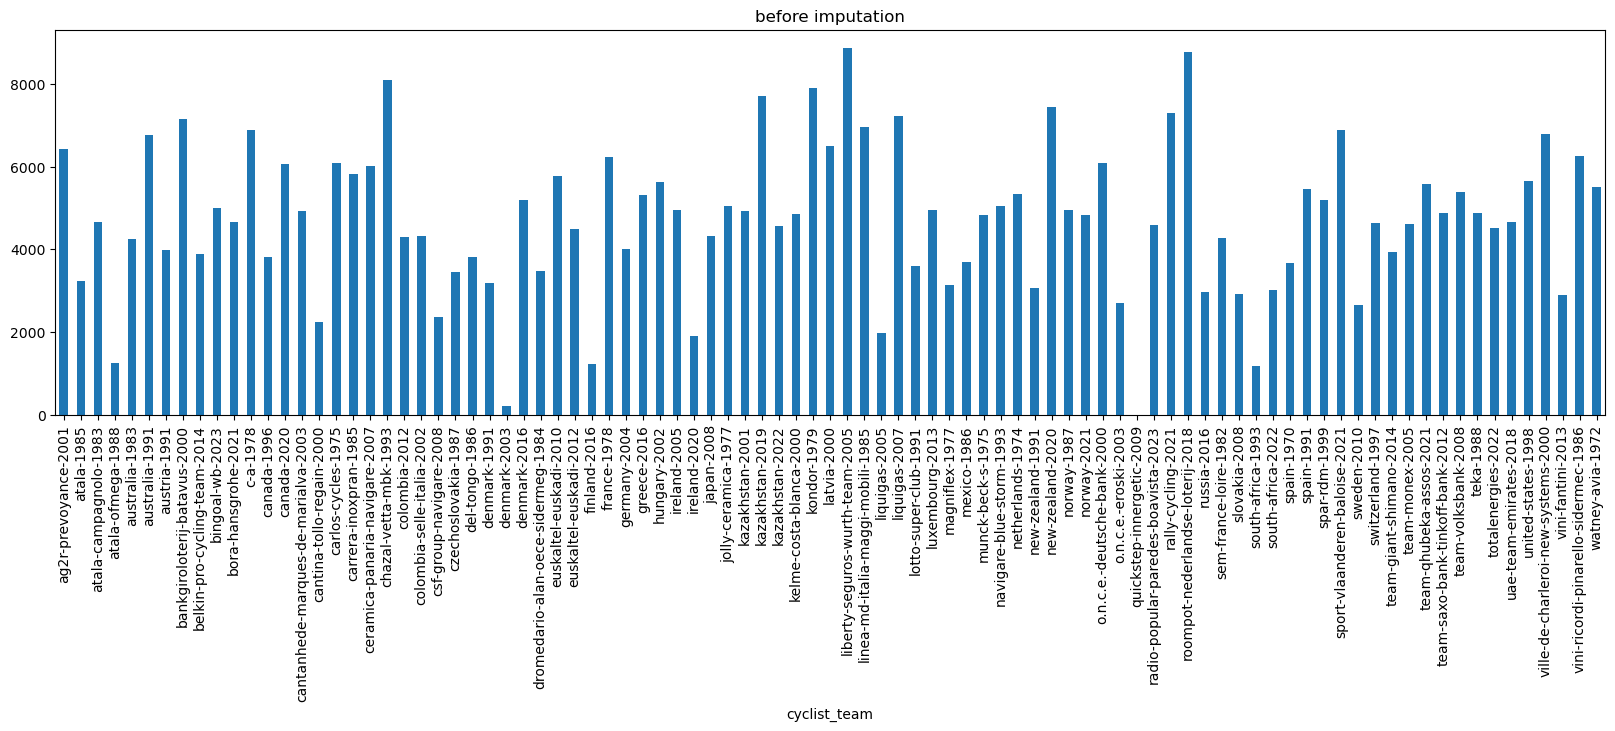

<Axes: title={'center': 'after imputation'}, xlabel='cyclist_team'>

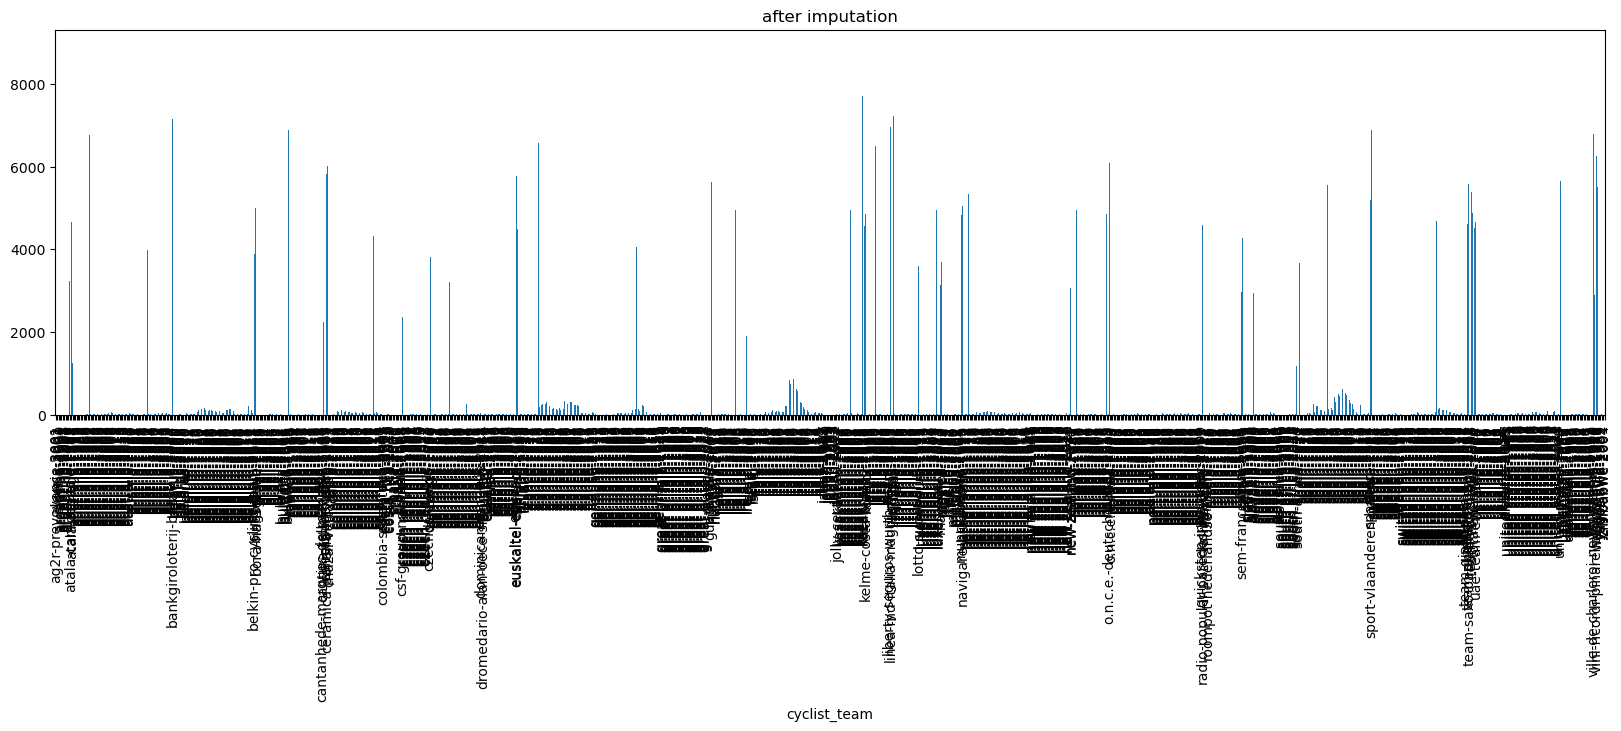

In [72]:
from os import path

CYCLIST_PATH=path.join('..','dataset','cyclists.csv')

cyclist_df=pd.read_csv(CYCLIST_PATH)

rec_races_df=races_df.copy()

mt_idx=races_df['cyclist_team'].isna()

def map_to_team(row):
    return f"{row['nationality'].lower()}-{row['date'].year}"

rec_races_df['cyclist_team'].value_counts().sort_index().plot(kind='bar',figsize=(20,5),title="before imputation")
plt.show()

rec_races_df.loc[mt_idx,'cyclist_team']=races_df[mt_idx].merge(cyclist_df,left_on='cyclist',right_on='_url')[['date','nationality']].apply(map_to_team,axis=1)
rec_races_df['cyclist_team'].value_counts().sort_index().plot(kind='bar',figsize=(20,5),title="after imputation")


Now there are some useful considerations to make: first of all we see that the distribution doesn't get altered significantly so we can use it tom ake further analysis without having missing values, second some races do not allow solo racers but it depends on single races and their rules.


# climb_total


# profile

From the previous analysis the missing profile seems to be related to climb_total in some way, a sensed way of deducing the association between values and categories seems to be sing the climb_total and observe taht high total correspond to a profile that is probably mountainous and lower ones correspond to flat with all the in betweens.

After some a sensible mapping seems to be that the following bins are thee most suited for filling in the missing values:
- \(0,50\] is for flat 
- \(50,300\] is for hilly
- \(300,1000\] is for mountains
- \(1000,+\inf\] is for high mountains.

The reason comes from the minimum meters used to define a hill/mountain/high mountain

As for filling in the missing values, from the previous plot of the missing values per racesit seems reasonable to impute for each race the most probable values using mode for each race,year couple we have in the dataset as to maintain the profile.

In [73]:
races_df_ext[['race_name','year']]=url_df[['name','year']]

def most_frequent(series):
    return series.mode()[0] if not series.mode().empty else np.nan

print(rec_races_df['profile'].value_counts(dropna=False))

rec_races_df['profile']= races_df_ext.groupby(['race_name','year'])['profile'].transform(
    most_frequent
)

rec_races_df['profile'].value_counts(dropna=False)

profile
NaN    148194
1.0    131344
2.0    128269
5.0     88203
3.0     50844
4.0     43011
Name: count, dtype: int64


profile
1.0    198897
2.0    161582
NaN    135393
5.0     61990
4.0     17836
3.0     14167
Name: count, dtype: int64

After the first try it's not enough, we managed to succesfully impute roughly 12000 values so far which is useless for our considerations, by our code abaove we can infer another serious problem: profile is missing entirely for some races.

In [74]:
#df=rec_races_df.sort_values(['race_name','year'])

rec_races_df[['race_name','year']]=url_df[['name','year']]
mp_df=rec_races_df.groupby(['race_name','year'])['profile'].apply(lambda x:x.isna().all())
mp_races=rec_races_df[['race_name','year']].drop_duplicates().loc[~mp_df.values,['race_name','year']]
mp_races

,race_name,year
4913,tirreno-adriatico,1999
5424,dauphine,1983
5429,la-fleche-wallone,2015
5562,vuelta-a-espana,2014
5756,giro-d-italia,2011
...,...,...
585859,milano-sanremo,1996
586221,amstel-gold-race,2013
588166,san-sebastian,2017
588250,gp-quebec,2010


The most sensed way to try and reconstruct profile is to understand the logic behind it through machine learning algorithms, a first test is to be done with Logistic regression.

First and foremost we split the dataset in training and validation using stratified sampling to maintain the distribution on the development set.


In [24]:
import seaborn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

hm_df=rec_races_df
hm_df['is_tarmac']=rec_races_df['is_tarmac'].astype(int)
hm_df['is_cobbled']=rec_races_df['is_cobbled'].astype(int)
hm_df['is_gravel']=rec_races_df['is_gravel'].astype(int)

cat_encoder=OneHotEncoder(handle_unknown='ignore')
cat_encoder.fit(hm_df.select_dtypes('string'))

cat_cols=hm_df.select_dtypes('string').columns

hm_df=pd.get_dummies(hm_df,columns=cat_cols)

data=hm_df[['is_tarmac','is_cobbled','is_gravel','race_name','profile','uci_points','length']]
train_set=data[~data['profile'].isna()]
test_set=data[data['profile'].isna()]

X_train_dev=train_set[['is_tarmac','is_cobbled','is_gravel','length']]
Y_train_dev=train_set['profile']

X_test=test_set[['is_tarmac','is_cobbled','is_gravel','length']]
Y_test=test_set['profile']


X_train,X_val,Y_train,Y_val=train_test_split(X_train_dev,Y_train_dev,test_size=0.2,stratify=Y_train_dev,random_state=42)



In [56]:

model = LogisticRegression()
model=model.fit(X_train,Y_train)
Y_pred=model.predict(X_train)
Y_pred_output_train=np.digitize(Y_pred,bins=[0,1.5,2.5,3.5,4.5,5.5])

Y_pred=model.predict(X_val)
Y_pred_output_val=np.digitize(Y_pred,bins=[0,1.5,2.5,3.5,4.5,5.5])

print("f1 score on training set",f1_score(Y_train,Y_pred_output_train,average='micro'))
print("f1 score on validation set",f1_score(Y_val,Y_pred_output_val,average='micro'))
Y_test_output=model.predict(X_test)
Y_test_output=np.digitize(Y_test_output,bins=[0,1.5,2.5,3.5,4.5,5.5])
Y_test_output

f1 score on training set 0.16673954254967258
f1 score on validation set 0.166588964544629


/home/mirdan08/anaconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([1, 1, 1, ..., 1, 1, 1])

In [88]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

import itertools as it


hyper_params={
    'n_neighbors':[5,10,20],
    'distances':['euclidean','l1','cosine']
}
results=pd.DataFrame({
    'n_neighbors':[],
    'distances':[]
})
print(list(hyper_params.keys()))
values=list(it.product(*hyper_params.values()))
for n_neighbors,distance in values:
    model = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        metric=distance,
        n_jobs=-1
    )

    model.fit(X_train,Y_train)
    train_pred=model.predict(X_train)
    train_f1=f1_score(Y_train,train_pred,average='micro')

    val_pred=model.predict(X_val)
    val_f1=f1_score(Y_val,val_pred,average='micro')
    print('training set:',train_f1,'validation set:',val_f1,'params',(n_neighbors,distance))
    results = pd.concat([results, pd.DataFrame([{
        'n_neighbors':n_neighbors,
        'metric':distance,
        'training':train_f1,
        'validation':val_f1,
    }])], ignore_index=True)

['n_neighbors', 'distances']
training set: 0.6442129177588242 validation set: 0.6452610154573959 params (5, 'euclidean')
training set: 0.6442129177588242 validation set: 0.6452610154573959 params (5, 'l1')
training set: 0.6542025485660534 validation set: 0.6541063864899059 params (10, 'euclidean')
training set: 0.6542025485660534 validation set: 0.6541063864899059 params (10, 'l1')
training set: 0.6626574288252557 validation set: 0.6627647285329226 params (20, 'euclidean')
training set: 0.6626574288252557 validation set: 0.6627647285329226 params (20, 'l1')


As we can see we didn't have much success, after some trials we decided that trying a random forest is better since he model is prone to be used with high dimensional datasets and thanks to it's use of ensambling should be able to avoid overfitting.

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

import itertools as it


hyper_params={
    'n_estimators':[100,200,500],
    'max_depth':[10,20,30],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[2,5,10]
}
results=pd.DataFrame({
    'n_estimators':[],
    'max_depth':[],
    'min_samples_split':[],
    'training':[],
    'validation ':[],
})
print(list(hyper_params.keys()))
values=list(it.product(*hyper_params.values()))
for n_estimators,max_depth,min_samples_split,min_samples_leaf in values:
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        n_jobs=-1
    )

    model.fit(X_train,Y_train)
    train_pred=model.predict(X_train)
    train_f1=f1_score(Y_train,train_pred,average='micro')

    val_pred=model.predict(X_val)
    val_f1=f1_score(Y_val,val_pred,average='micro')
    print('training set:',train_f1,'validation set:',val_f1,'params',(n_estimators,max_depth,min_samples_split))
    results = pd.concat([results, pd.DataFrame([{
        'n_estimators':n_estimators,
        'max_depth':max_depth,
        'min_samples_split':min_samples_split,
        'training':train_f1,
        'validation':val_f1,
    }])], ignore_index=True)

['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']
training set: 0.5564790952122934 validation set: 0.5566092744375378 params (100, 10, 2)
training set: 0.5570126823203888 validation set: 0.5569393255954673 params (100, 10, 2)
training set: 0.5557447253264095 validation set: 0.5558391550690357 params (100, 10, 2)
training set: 0.5489373640246771 validation set: 0.548501017657737 params (100, 10, 5)
training set: 0.5584154113158973 validation set: 0.558182518290335 params (100, 10, 5)
training set: 0.5551231238499685 validation set: 0.555465097090049 params (100, 10, 5)
training set: 0.5473145991083044 validation set: 0.5468617635733539 params (100, 10, 10)
training set: 0.5563278205166994 validation set: 0.5562572198690797 params (100, 10, 10)
training set: 0.5497845023200038 validation set: 0.5491721216788602 params (100, 10, 10)
training set: 0.667712754107108 validation set: 0.6691457175862259 params (100, 20, 2)
training set: 0.6662550161313835 validation set: 0

In [85]:
results.sort_values(by=['validation'],ascending=False)

,n_estimators,max_depth,min_samples_split,training,validation,validation
49,200.0,30.0,5.0,0.678052,NaN,0.677969
25,100.0,30.0,10.0,0.677994,NaN,0.677859
24,100.0,30.0,10.0,0.677983,NaN,0.677848
48,200.0,30.0,5.0,0.678060,NaN,0.677793
53,200.0,30.0,10.0,0.677859,NaN,0.677782
...,...,...,...,...,...,...
32,200.0,10.0,5.0,0.550725,NaN,0.550415
59,500.0,10.0,5.0,0.549776,NaN,0.549425
8,100.0,10.0,10.0,0.549785,NaN,0.549172
3,100.0,10.0,5.0,0.548937,NaN,0.548501


In [76]:
n_estimators,max_depth,min_samples_split=values[results['validation'].argmax()]

rfc=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,min_samples_split=min_samples_split,n_jobs=-1)
rfc=rfc.fit(X_train_dev,Y_train_dev)
Y_test=rfc.predict(X_test)
rec_races_df.loc[data['profile'].isna(),'profile']=Y_test

# uci_points

As for the missing uci_points it seems that values prior to 2000s are not available hence we need to consider only points from 2000 onward to be able to get a sensed imputation

In [77]:
up_idx=races_df['date'].dt.year>=2000

mean_val=races_df.loc[up_idx,'uci_points'].mean()
rec_races_df[up_idx].fillna(mean_val,inplace=True)

/tmp/ipykernel_997/1784264035.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_races_df[up_idx].fillna(mean_val,inplace=True)


# cyclist_age


In [78]:
rec_races_df.loc[rec_races_df['cyclist_age'].isna(),'cyclist_age']=rec_races_df['cyclist_age'].mean()

# points


In [79]:
rec_races_df.loc[rec_races_df['points'].isna(),'points']=rec_races_df['points'].mean()

In [80]:
rec_races_df.drop(columns=['average_temperature','uci_points']).isna().sum()

_url                      0
name                      0
points                    0
length                    0
climb_total          147045
profile                   0
startlist_quality         0
date                      0
position                  0
cyclist                   0
cyclist_age               0
is_tarmac                 0
is_cobbled                0
is_gravel                 0
cyclist_team         115347
delta                     0
race_name                 0
year                      0
dtype: int64

# values reconstruction
The most missing value to be used in the dataset is clearly the average temperature, to solve this issue we came up with a strategy that involves gathering external data in our dataset.

After som thorough research we've came up with the website procyclingstats and an API that can scrape data from it.

Note: there are many alternatives much more complete and suitable for this,however they also have time limits for requests or costly monthly plans so we resorted to this to keep down time and avoid any kind of expense.

In [32]:
RACES_PATH="./races_api_data.json"
GEODATA_PATH='./geodata.csv'

Due to the time needed to gather data we saved all the fathered that in a json file to work with it later, the code below uses the API to gather data from the website regarding the stages since it's what we need and then saves every information in a json file.

In [33]:
from os import path
if not path.exists(RACES_PATH):
    utils.fetch_from_procyclingstas(races_df,RACES_PATH)

AttributeError: module 'utils' has no attribute 'fetch_from_procyclingstas'

First we load in a dataframe the relevant data, in this case we take the names of the the arrival and departure places for each stage, this information is not present in the dataset and therefore was retrieved using the API in the code above.

In [34]:
import json
import pandas as pd

with open(RACES_PATH,'r') as f:
    data=json.load(f)

stages_df=pd.DataFrame([{
                    'url':stage['url'],
                    'departure':stage['departure'],
                    'arrival':stage['arrival'],
                } 
              for stage in data])
stages_df

FileNotFoundError: [Errno 2] No such file or directory: './races_api_data.json'

from the retrieved values we can take advantage of aecond api to get geocoordinates of any place,further enriching the information we gather.

In [35]:
from geopy.geocoders import Nominatim

places_info=utils.map_place_to_point(stages_df,Nominatim(user_agent="Mirko"))

ModuleNotFoundError: No module named 'geopy'

we load the obatined info into a dataframe and save the results for later usage.

In [36]:
geo_df=pd.DataFrame([{
    'name':info.raw['name'],
    'altitude':info.altitude,
    'longitude':info.longitude,
    'latitude':info.latitude
}for info in places_info])

geo_df.to_csv(GEODATA_PATH)

geo_df

NameError: name 'places_info' is not defined

Finaly we can associate the given information we gathered into a single dataframe

In [37]:
geo_df=pd.read_csv(GEODATA_PATH)

temp_df=stages_df.merge(right=geo_df,left_on='departure',right_on='name')
temp_df=temp_df.merge(right=geo_df,left_on='arrival',right_on='name',suffixes=('_arr',''))
temp_df=temp_df.drop(columns=['name','name_arr']).drop_duplicates()
temp_df

FileNotFoundError: [Errno 2] No such file or directory: './geodata.csv'

using the geospatial data we can reconstruct the average temperatuer using the meteostat API to gain access to historical data about the weather,including the temperature.

In [38]:
from meteostat import Point,Hourly,Daily
from datetime import datetime

race_stage_df=races_df.groupby('_url')

race_stage_df=race_stage_df.agg('first').drop(columns='average_temperature')

arr_temp_df=temp_df[['arrival','altitude_arr','longitude_arr','latitude_arr']]

def fetch_temp(df_row):
    point=Point(df_row['latitude'],df_row['longitude'])
    dt=df_row['date'].to_pydatetime()

    hourly=Daily(point,start=dt,end=dt)
    data=hourly.fetch()
    if not data.empty:
        print(data)

data=pd.merge(left=race_stage_df[['date']],
              left_on=race_stage_df.index,
              right=temp_df,
              right_on=temp_df.index
              )
data.apply(fetch_temp,axis=1)

ModuleNotFoundError: No module named 'meteostat'

However the API demonstrated to be incomplete,difficult to use andvery imprecise at least during our efforts, so we decided given the time and resoruces limit to stop going down this path.

Some further enhance could be obtained by switch to paid services,like Strava, or manually searching some other sources of geospatial data.

In [39]:
from os import path
import pandas as pd
CYCLIST_PATH=path.join('..','dataset','races.csv')

cyclist_df=pd.read_csv(CYCLIST_PATH)

missing_idx=races_df['cyclist_team'].isna()

races_df[missing_idx]['cyclist_team']="free-agent"

races_df.merge(cyclist_df,left_on='_url',right_on='_url')

/tmp/ipykernel_940/1197539650.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  races_df[missing_idx]['cyclist_team']="free-agent"


: 